In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
import json
import io
# Install Kaggle library
!pip install -q kaggle
import os
os.environ['KAGGLE_USERNAME'] = "comp540jx24" # username from the json file
os.environ['KAGGLE_KEY'] = "ff43bff394af31725e0e8929b78ee4da" # key from the json file
!kaggle competitions download -c ifood-2019-fgvc6 # api copied from kaggle
!unzip train_set.zip
!unzip val_set.zip
!unzip test_set.zip
!unzip train_labels.csv.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_set/test_009481.jpg  
  inflating: test_set/test_013960.jpg  
  inflating: test_set/test_002362.jpg  
  inflating: test_set/test_005803.jpg  
  inflating: test_set/test_015388.jpg  
  inflating: test_set/test_002764.jpg  
  inflating: test_set/test_021964.jpg  
  inflating: test_set/test_013738.jpg  
  inflating: test_set/test_016448.jpg  
  inflating: test_set/test_022310.jpg  
  inflating: test_set/test_002203.jpg  
  inflating: test_set/test_003963.jpg  
  inflating: test_set/test_022431.jpg  
  inflating: test_set/test_003303.jpg  
  inflating: test_set/test_006227.jpg  
  inflating: test_set/test_016860.jpg  
  inflating: test_set/test_009457.jpg  
  inflating: test_set/test_020554.jpg  
  inflating: test_set/test_003655.jpg  
  inflating: test_set/test_006939.jpg  
  inflating: test_set/test_003241.jpg  
  inflating: test_set/test_020979.jpg  
  inflating: test_set/test_027004.jpg  
  inflating: test_set/test_02

In [0]:
import gc 
gc.collect()

15

In [0]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=074cac70fc5f3525b8fcddf1d240e0884e70694b870239aff8d168de797b48ec
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
import pretrainedmodels

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_dir = 'train_set/'
val_dir = 'val_set/'
train_df = pd.read_csv('train_labels.csv')
val_df = pd.read_csv('val_labels.csv')
train_df['path'] = train_dir+ train_df['img_name']
val_df['path']  =  val_dir+ val_df['img_name']
df = pd.concat([train_df, val_df], ignore_index=True)
df.head()
val_idx = [i for i in range(len(train_df), len(df))]

In [0]:
sz = 256
bs = 128

In [0]:
#np.random.seed(142)
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_warp=0.1,
                      max_rotate = 20,
                      max_zoom=1.4,
                      max_lighting=0.2,
                      p_lighting=0.2, 
                      p_affine=0.4
                      ) #change as needed
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset
       .split_by_idx(val_idx)
       .label_from_df(cols='label') #obtain labels
      )
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='border') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [0]:
gc.collect()

0

In [0]:
def top_3(preds, targs):
    return top_k_accuracy(preds, targs, 3)

In [0]:
learner = cnn_learner(data, models.resnet50, metrics=[accuracy, top_3],loss_func = LabelSmoothingCrossEntropy())


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learner = learner.load('/content/drive/My Drive/Colab Notebooks/stage-experimental_top_3_Resnet50')

In [0]:
learner.validate()

[2.3462112, tensor(0.6680), tensor(0.8418)]

In [0]:
gc.collect()

0

In [0]:
learner.fit_one_cycle(10, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,accuracy,top_3,time
0,2.108024,2.163465,0.668668,0.840754,09:30
1,2.109946,2.150623,0.669752,0.840754,09:30
2,2.093765,2.140803,0.669168,0.838252,09:30
3,2.070621,2.132958,0.669168,0.840337,09:31
4,2.073516,2.128515,0.668418,0.840920,09:30
5,2.065393,2.124989,0.669668,0.840920,09:31


KeyboardInterrupt: ignored

In [0]:
learner.validate()

[1.9510227, tensor(0.7093), tensor(0.8676)]

In [0]:
learner.save('/content/drive/My Drive/Colab Notebooks/stage-experimental_top_3_Resnet50')

In [0]:
#learner = learner.load('/content/drive/My Drive/Colab Notebooks/stage-experimental_top_3_Resnet50')

In [0]:
learner.validate()

[2.3462112, tensor(0.6680), tensor(0.8418)]

In [0]:
learner.fit(5, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,top_3,time
0,2.095160,2.126450,0.670335,0.842088,10:01


KeyboardInterrupt: ignored

In [0]:
#learner.save('/content/drive/My Drive/Colab Notebooks/stage-experimental_Resnet101')

In [0]:
learner.validate()

[2.9968789, tensor(0.5454), tensor(0.7357)]

In [0]:
pretrainedmodels.pretrained_settings['nasnetalarge']

{'imagenet': {'input_range': [0, 1],
  'input_size': [3, 331, 331],
  'input_space': 'RGB',
  'mean': [0.5, 0.5, 0.5],
  'num_classes': 1000,
  'std': [0.5, 0.5, 0.5],
  'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth'},
 'imagenet+background': {'input_range': [0, 1],
  'input_size': [3, 331, 331],
  'input_space': 'RGB',
  'mean': [0.5, 0.5, 0.5],
  'num_classes': 1001,
  'std': [0.5, 0.5, 0.5],
  'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth'}}

In [0]:
def get_cadene_model(pretrained=True, model_name='se_resnext101_32x4d'):
    if pretrained:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
    return arch

In [0]:
arch = get_cadene_model


In [0]:
learn = cnn_learner(data, get_cadene_model, metrics=[accuracy, top_3_accuracy], loss_func = LabelSmoothingCrossEntropy()).mixup()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth


In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,4.881779,3.885101,0.237035,0.407454,07:35
1,4.408239,3.436094,0.338503,0.533350,07:31
2,4.179504,3.176929,0.396031,0.599800,07:29
3,4.077647,3.054127,0.428131,0.630565,07:30
4,4.030302,3.016623,0.437135,0.634067,07:30


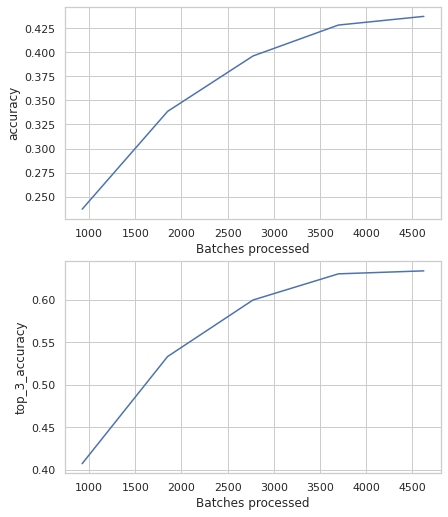

In [0]:
learn.recorder.plot_metrics()

In [0]:
#resnext 
max_lr = 3e-4
learn.fit_one_cycle(5, max_lr = max_lr)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,4.074814,3.039601,0.429882,0.630732,07:31
1,4.087730,3.003145,0.437219,0.640570,07:31
2,3.990342,2.902796,0.461064,0.660414,07:31
3,3.932311,2.830282,0.477822,0.677005,07:32
4,3.874908,2.810810,0.482491,0.680424,07:31


In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.857481,2.800306,0.483909,0.679256,07:32
1,3.927561,2.825457,0.481324,0.679673,07:33
2,3.937471,2.822689,0.481658,0.679757,07:32
3,3.911528,2.796009,0.486993,0.686843,07:32
4,3.874510,2.746615,0.501001,0.699767,07:32
5,3.811061,2.708253,0.508838,0.701851,07:33
6,3.775376,2.668348,0.519927,0.716358,07:33
7,3.742230,2.649517,0.521761,0.721694,07:33
8,3.729838,2.631968,0.523095,0.720777,07:34
9,3.722106,2.633274,0.525680,0.722194,07:32


In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.693542,2.627484,0.526680,0.722028,07:34
1,3.754833,2.657439,0.518259,0.718943,07:34
2,3.811642,2.687651,0.510005,0.712856,07:36
3,3.785183,2.667334,0.519260,0.714857,07:36
4,3.796275,2.655576,0.517759,0.713273,07:36
5,3.743717,2.618038,0.526847,0.721861,07:37
6,3.723504,2.589723,0.531849,0.729782,07:37
7,3.670287,2.564590,0.540854,0.734034,07:37


In [0]:
#learn = learn.load('/content/drive/My Drive/Colab Notebooks/stage-1-experimental-Resnext101')

In [0]:
max_lr = 3e-2
wd = 1e-5
learn.fit_one_cycle(6, max_lr = max_lr)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,5.008833,6.498107,0.137152,0.263215,12:14


KeyboardInterrupt: ignored

In [0]:
max_lr = 3e-4
learn.fit_one_cycle(6, max_lr = max_lr)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.186504,2.259611,0.615975,0.794897,07:32
1,3.162228,2.247536,0.615141,0.797149,07:32
2,3.172532,2.239990,0.616558,0.797399,07:31


KeyboardInterrupt: ignored

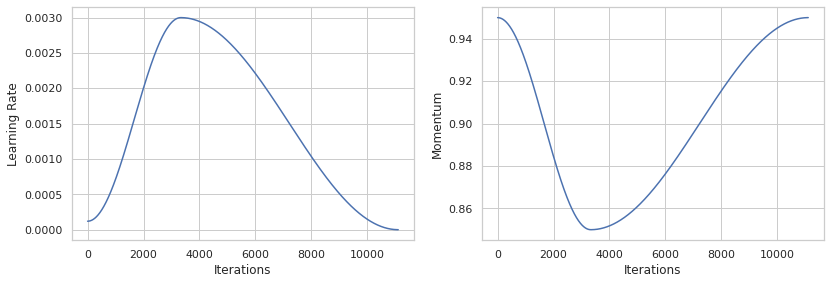

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.806411,1.934621,0.706937,0.866266,20:36


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('/content/drive/My Drive/Colab Notebooks/stage-1-Resnext101')

In [0]:
learn.validate()

[1.9002624, tensor(0.8736)]

In [0]:
learn.validate()

[1.8991199, tensor(0.7118), tensor(0.8718)]

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


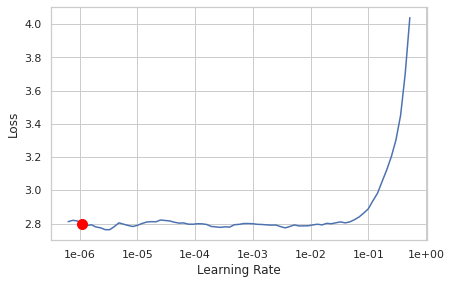

In [0]:
learn.recorder.plot(suggestion=True)

**TEST**


In [0]:
test = ImageList.from_folder('test_set/')
data.add_test(test)

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
fnames = [f.name for f in learn.data.test_ds.items]

In [0]:
fnames[:4]

['test_023163.jpg', 'test_018436.jpg', 'test_015034.jpg', 'test_026287.jpg']

In [0]:
col = ['img_name']
test_df = pd.DataFrame(fnames, columns=col)
test_df['label'] = ''

In [0]:
predictions = np.array(preds).reshape(len(preds), 251)
predictions.shape

(28377, 251)

In [0]:
from tqdm import tqdm_notebook as T
for i, pred in T(enumerate(predictions), total=len(predictions)):
    test_df.loc[i, 'label'] = ' '.join(str(int(i)) for i in np.argsort(pred)[::-1][:3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
df_example = pd.read_csv('ifood2019_sample_submission.csv')
test_df = pd.merge(df_example['img_name'], test_df )

In [0]:
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/top_3_exp_submission_Resnext101.csv', index=False)

In [0]:
test_df

,img_name,label
0,test_000000.jpg,179 143 27
1,test_000001.jpg,16 25 177
2,test_000002.jpg,88 133 155
3,test_000003.jpg,102 201 117
4,test_000004.jpg,56 157 232
...,...,...
28372,test_028394.jpg,1 39 220
28373,test_028395.jpg,232 102 164
28374,test_028396.jpg,107 212 234
28375,test_028397.jpg,244 4 29


In [0]:
test_df

,img_name,label
0,test_000000.jpg,140 224 179
1,test_000001.jpg,16 27 177
2,test_000002.jpg,88 155 133
3,test_000003.jpg,232 117 51
4,test_000004.jpg,232 51 106
...,...,...
28372,test_028394.jpg,220 1 39
28373,test_028395.jpg,164 232 106
28374,test_028396.jpg,111 96 234
28375,test_028397.jpg,244 160 202
